In [1]:
!unzip /content/img_HRsumary4357.zip

Archive:  /content/img_HRsumary4357.zip
replace img_HRsumary/0054_05705_b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!unzip /content/img_LRsumary4357.zip

Archive:  /content/img_LRsumary4357.zip
replace img_LRsumary/0054_05705_b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from PIL import Image

# Class Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


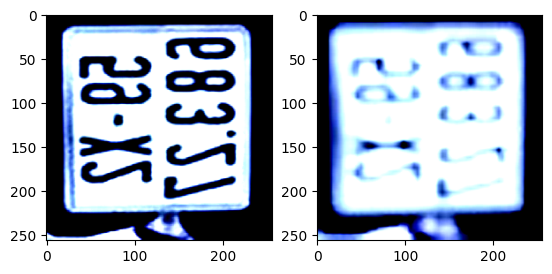

In [2]:
class LicensePlateDataset(Dataset):
    def __init__(self, LR_folder_path,HR_folder_path, resize_tup):
        super().__init__()
        self.LR_folder_path = LR_folder_path
        self.HR_folder_path = HR_folder_path
        self.resize_tup = resize_tup
        self.transforms = transforms.Compose([
            transforms.Resize(self.resize_tup),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
        ])
    def __len__(self):
        if os.listdir(self.LR_folder_path) != os.listdir(self.HR_folder_path):
            raise ValueError("HR image number is not same LR image number!")

        return len(os.listdir(self.LR_folder_path))

    def __getitem__(self, index):
        LR_tail = os.listdir(self.LR_folder_path)
        LR_image = Image.open(os.path.join(self.LR_folder_path,LR_tail[index]))
        LR_image = self.transforms(LR_image)
        HR_tail = os.listdir(self.HR_folder_path)
        HR_image = Image.open(os.path.join(self.HR_folder_path,HR_tail[index]))
        HR_image = self.transforms(HR_image)
        return (LR_image, HR_image)

# Path of image folder
LR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_augmentation\img_HRsumary4357\img_HRsumary"
HR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_augmentation\img_LRsumary4357\img_LRsumary"
Dataset = LicensePlateDataset(LR_path, HR_path, (256,256))

image_test1 = Dataset.__getitem__(1)[0]
image_test1 = image_test1.transpose(2,0)
image_test2 = Dataset.__getitem__(1)[1]
image_test2 = image_test2.transpose(2,0)
plt.subplot(1,2,1)
plt.imshow(image_test1)
plt.subplot(1,2,2)
plt.imshow(image_test2)
plt.show()

# Model UNET

In [3]:
in_channels=3
out_channels=3
class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self,x):
        x=self.conv(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels=in_channels, out_channels=out_channels, features=[64,128]):
        super().__init__()
        self.downs=nn.ModuleList()
        self.ups=nn.ModuleList()
        self.Maxpool2d=nn.MaxPool2d(kernel_size=2,stride=2)

        for feature in features:
            self.downs.append(DoubleConv2d(in_channels,feature))
            in_channels=feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(in_channels=feature*2,out_channels=feature,padding=2,stride=2,kernel_size=2)
            )
            self.ups.append(DoubleConv2d(feature*2,feature))

        self.bottom=DoubleConv2d(features[-1],features[-1]*2)
        self.lastConv2d=nn.Conv2d(features[0],out_channels,kernel_size=1)

    def forward(self,x):
        skip_connections=[]
        for down in self.downs:
            x=down(x)
            skip_connections.append(x)
            x=self.Maxpool2d(x)

        x=self.bottom(x)
        skip_connections=skip_connections[::-1]

        for i in range(0,len(self.ups),2):
            x=self.ups[i](x)
            skip_connection=skip_connections[i//2]


            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            x=torch.cat((x,skip_connection),dim=1)
            x=self.ups[i+1](x)

        x=self.lastConv2d(x)
        return x

In [9]:
import torch

# Giả sử tensor là một tensor trên GPU
torch.cuda.empty_cache()


# Training

In [4]:
epochs = 10
device = 'cuda'
loss_fn = nn.MSELoss()

image_dataset = LicensePlateDataset(LR_path, HR_path, (256, 256))
dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)
model = UNET(in_channels=3, out_channels=3)
model.to(device)
optimizer = Adam(model.parameters(),lr=0.001)

for epoch in range(epochs):
  model.train()
  sum_loss = 0
  n=len(dataloader)
  for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        optimizer.zero_grad()
        HR_output = model(LR_image)
        loss = loss_fn(HR_output, HR_image)
        loss.backward()
        optimizer.step()
        sum_loss+=loss
  print("Epoch {} : Loss {}".format(epoch+1,sum_loss/n))

Epoch 1 : Loss 0.23294347524642944
Epoch 2 : Loss 0.19286082684993744
Epoch 3 : Loss 0.16757871210575104
Epoch 4 : Loss 0.1570757031440735
Epoch 5 : Loss 0.14419293403625488
Epoch 6 : Loss 0.13486802577972412
Epoch 7 : Loss 0.12945657968521118
Epoch 8 : Loss 0.12446174025535583
Epoch 9 : Loss 0.11897507309913635
Epoch 10 : Loss 0.11479157209396362


# Save Model

In [5]:

torch.save(model.state_dict(), 'model_weights.pth')


# Load Model


In [5]:
model_path = r"D:\LPD_LPR_SR_Proposal\model\SR\UNET\model_weights.pth"
model = UNET()
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

# Inference


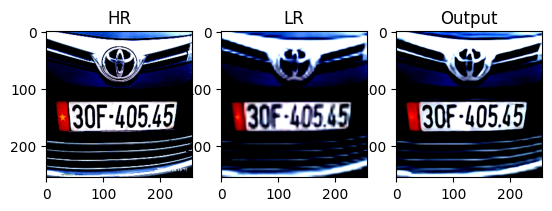

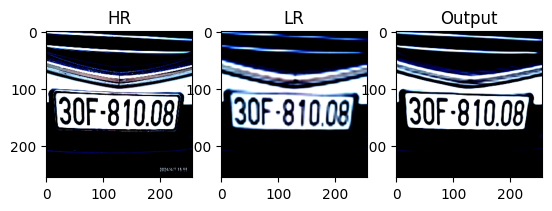

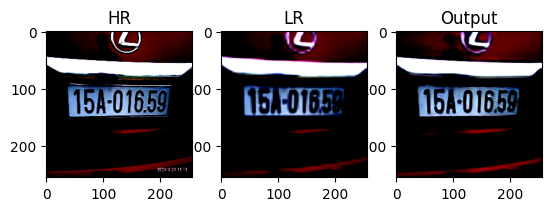

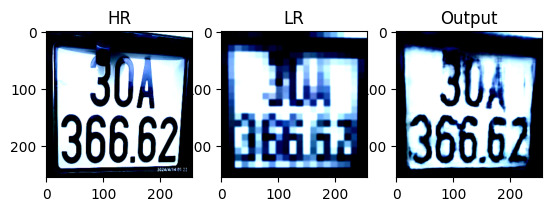

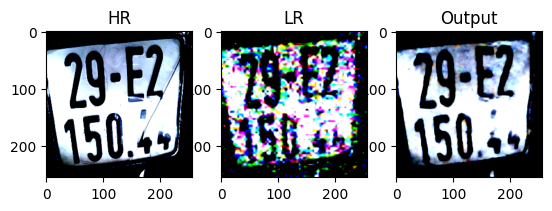

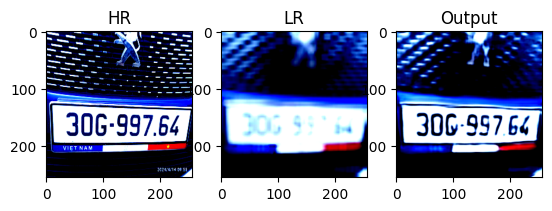

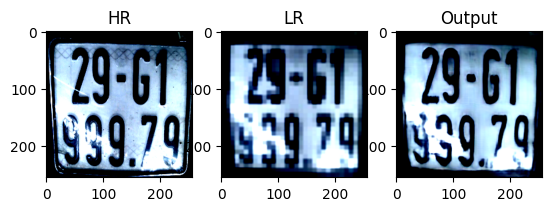

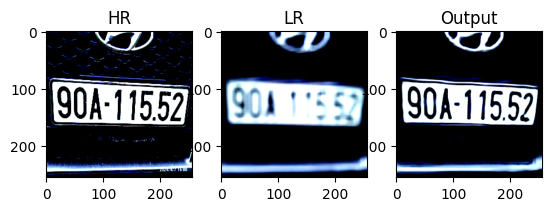

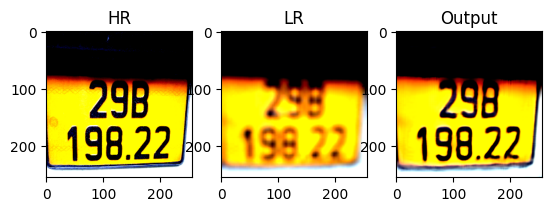

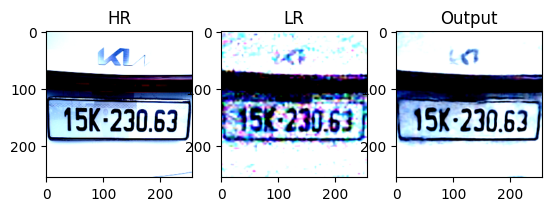

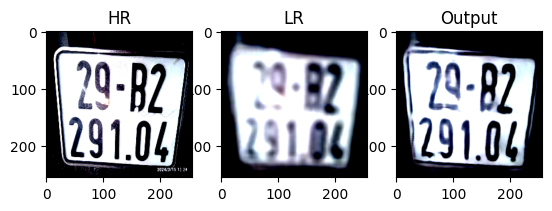

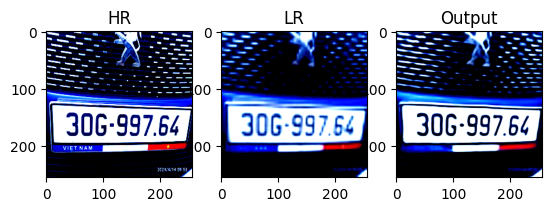

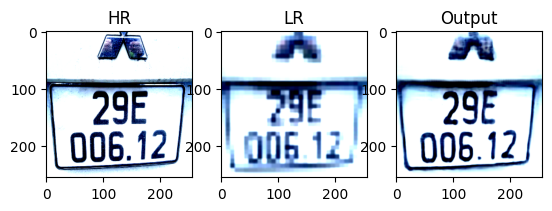

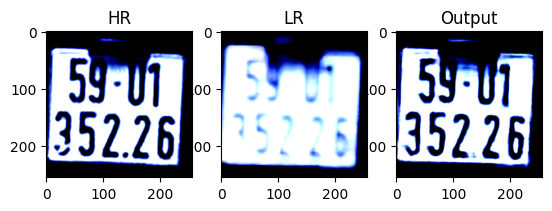

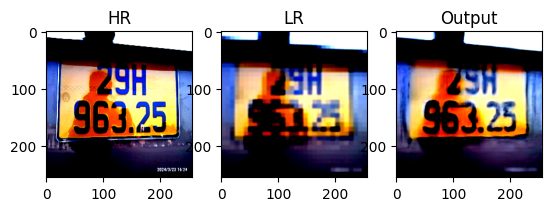

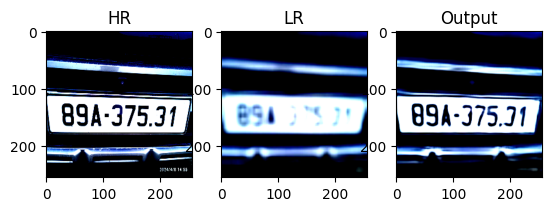

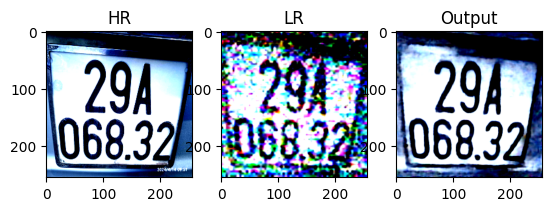

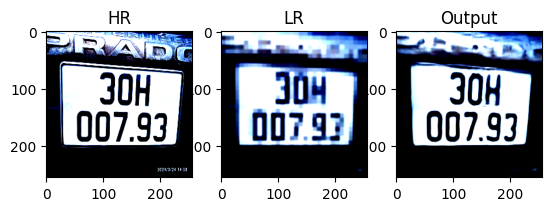

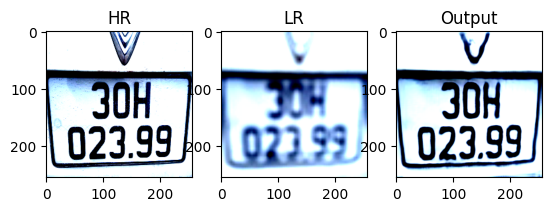

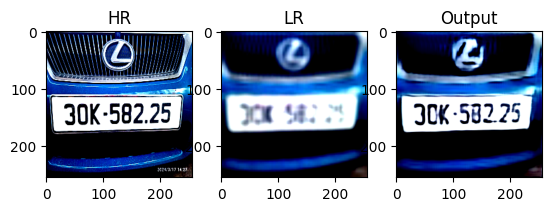

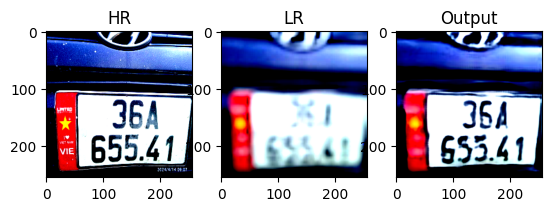

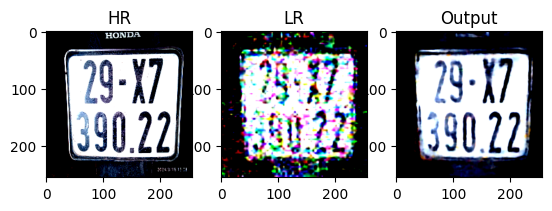

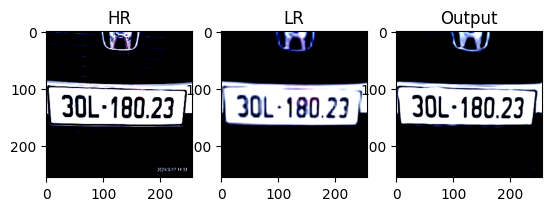

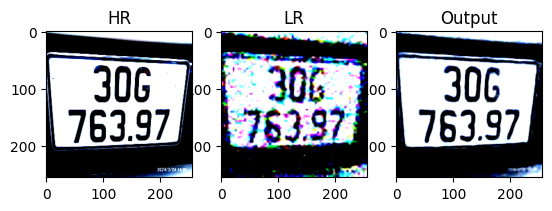

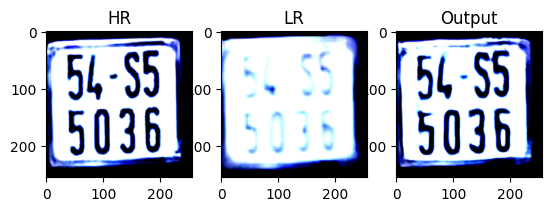

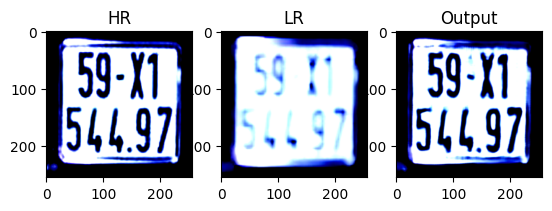

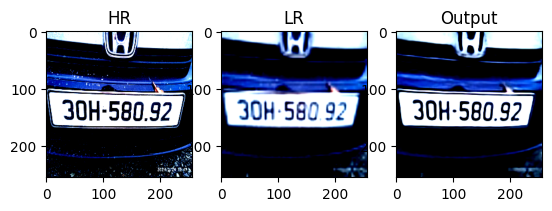

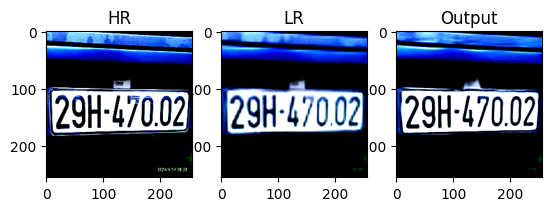

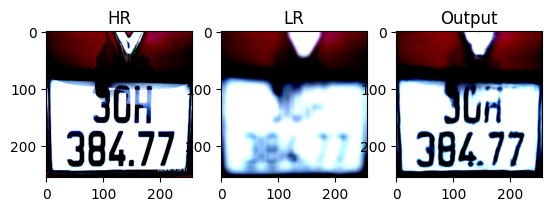

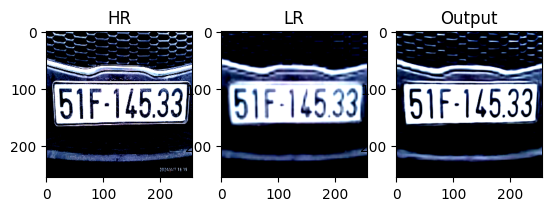

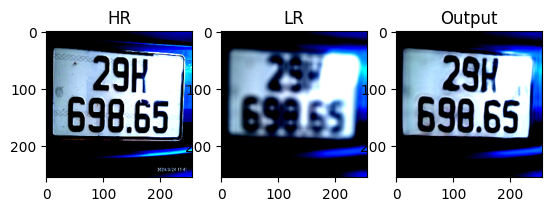

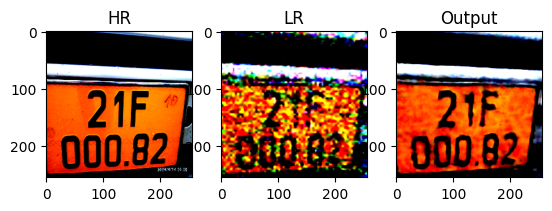

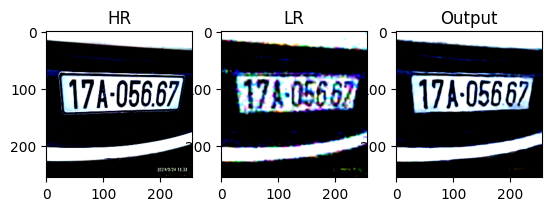

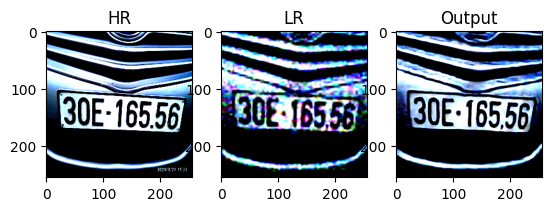

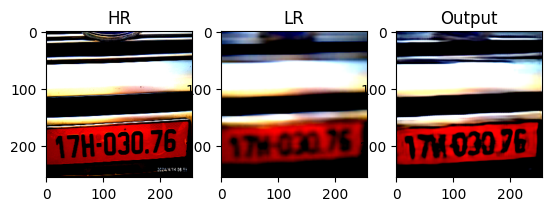

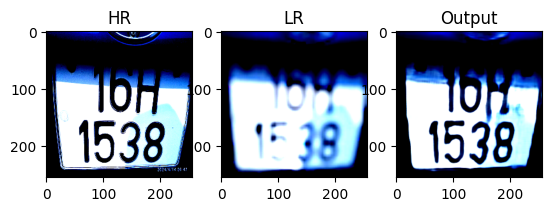

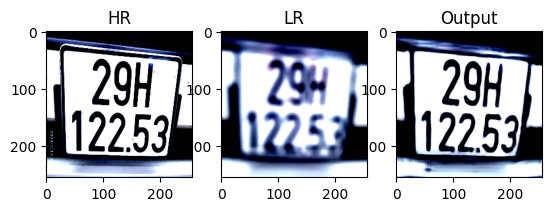

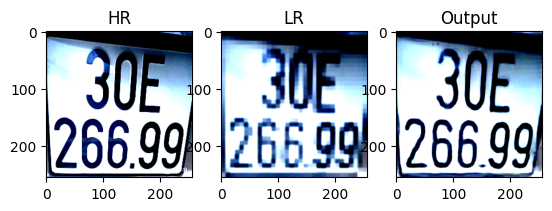

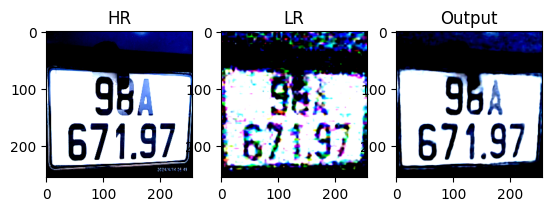

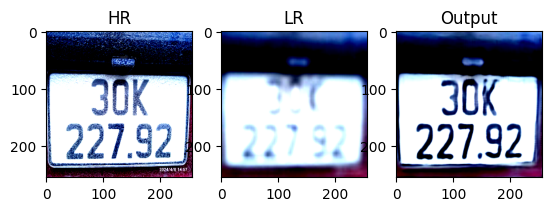

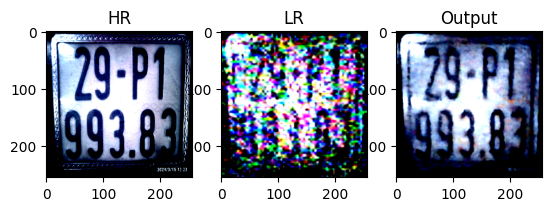

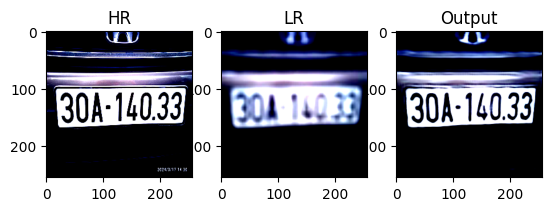

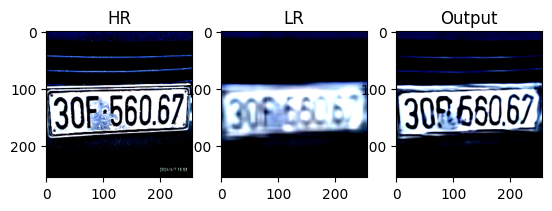

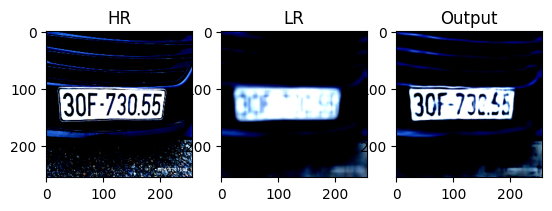

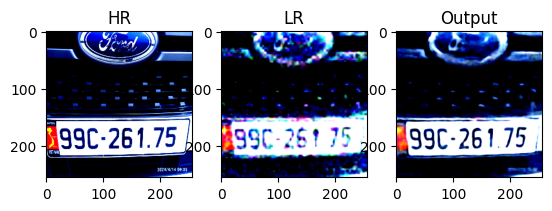

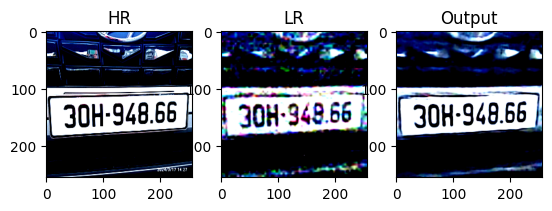

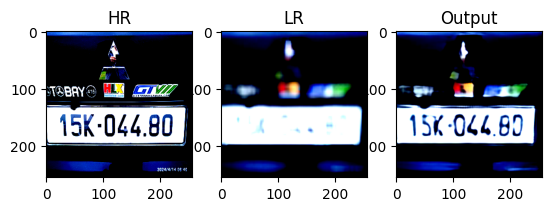

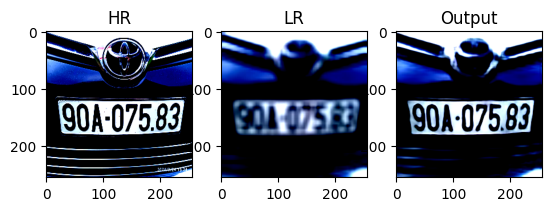

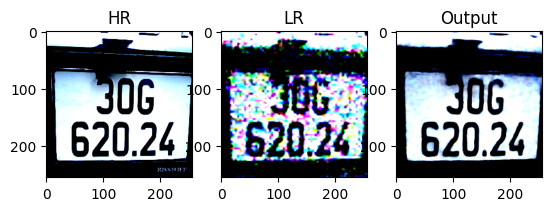

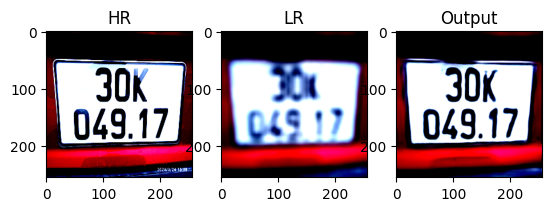

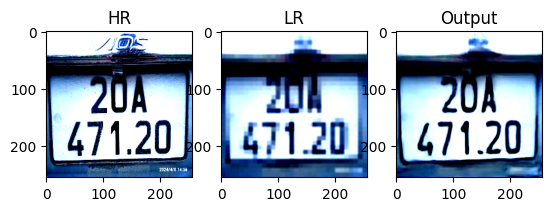

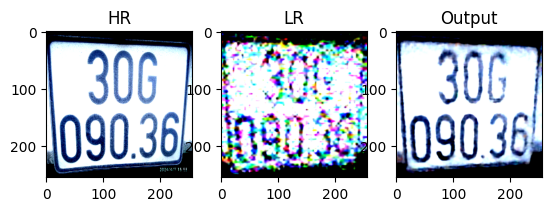

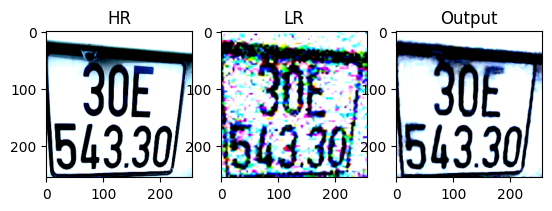

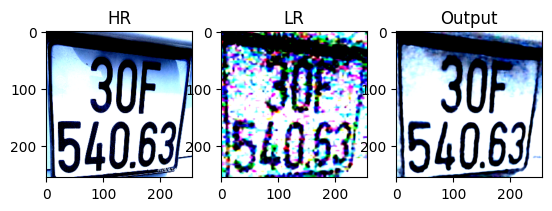

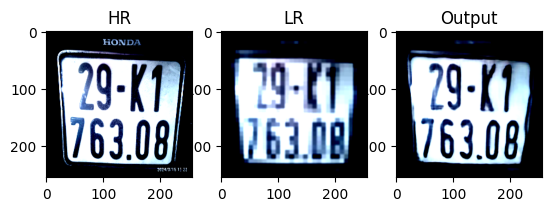

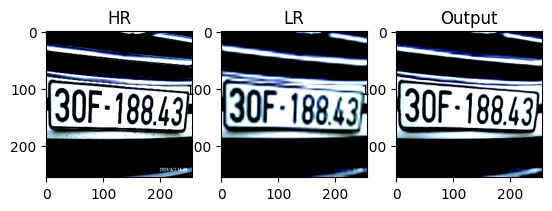

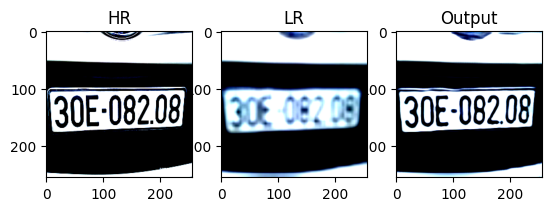

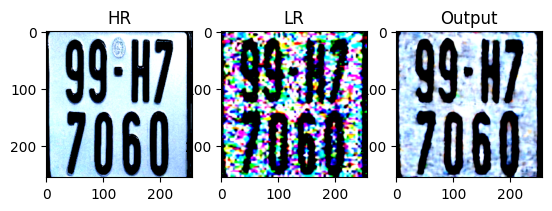

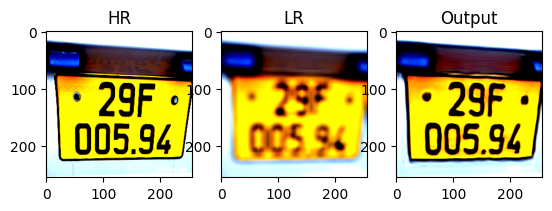

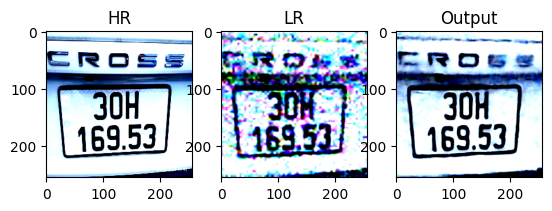

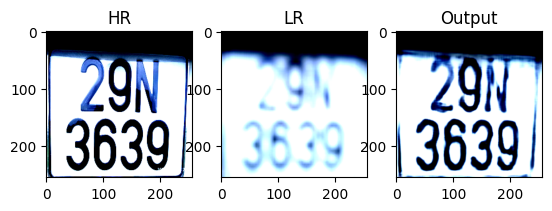

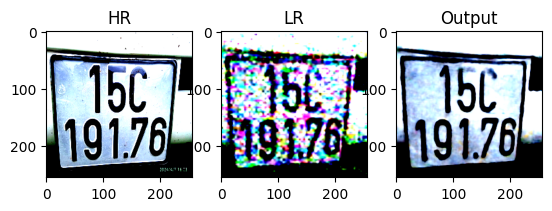

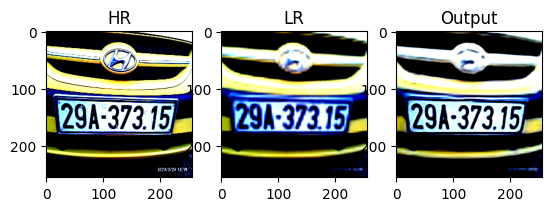

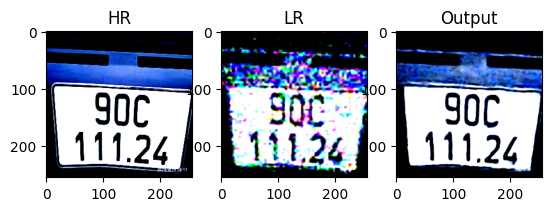

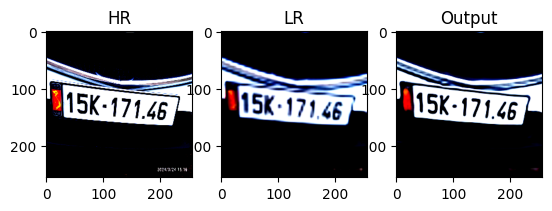

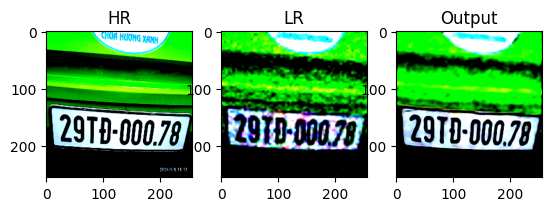

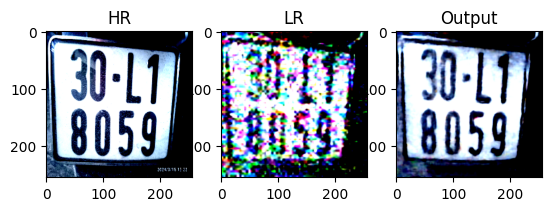

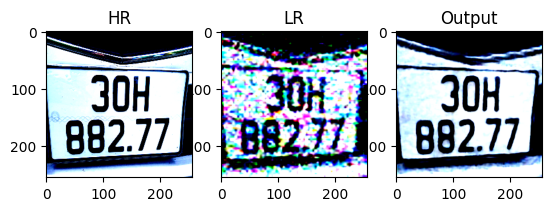

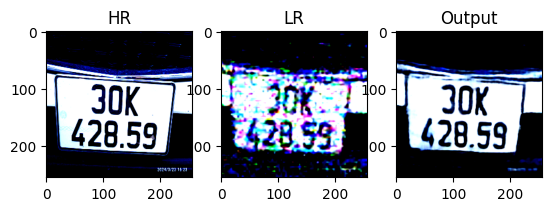

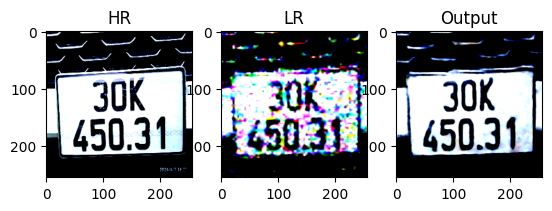

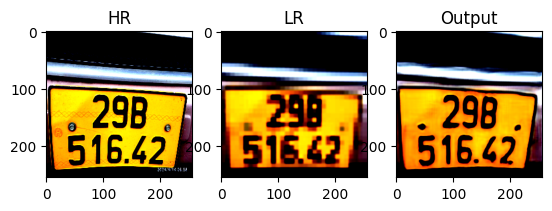

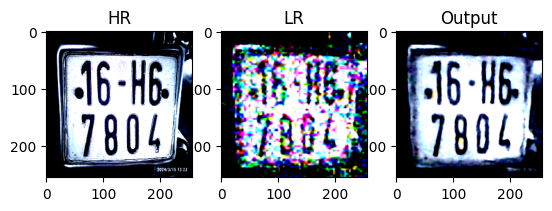

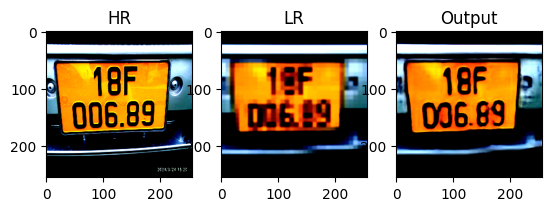

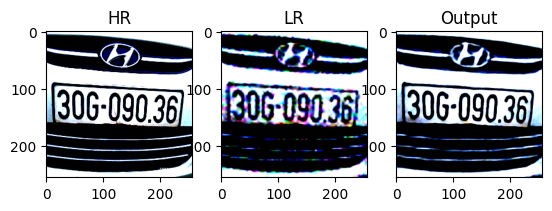

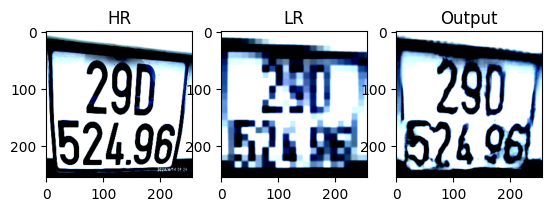

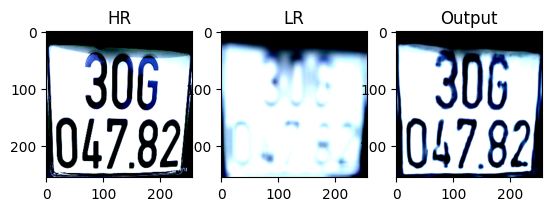

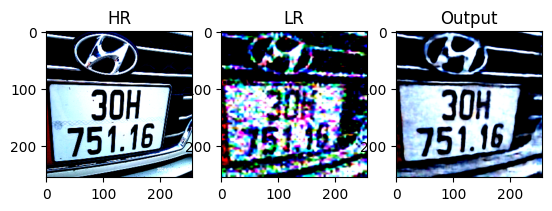

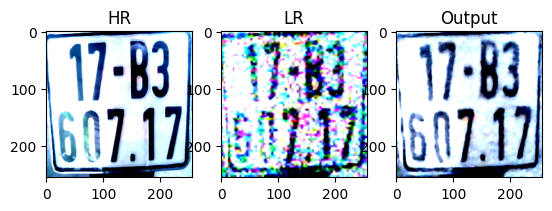

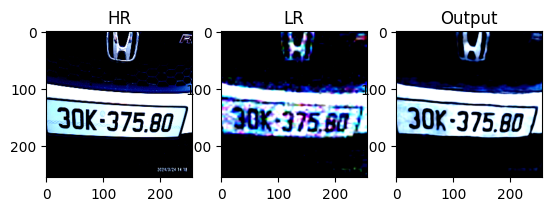

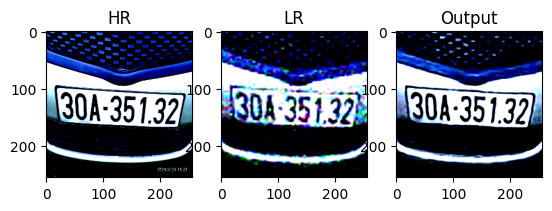

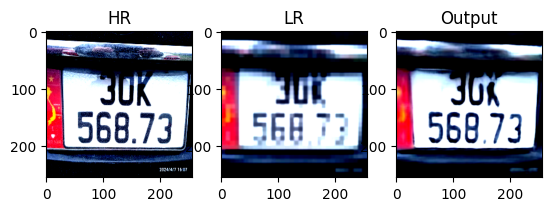

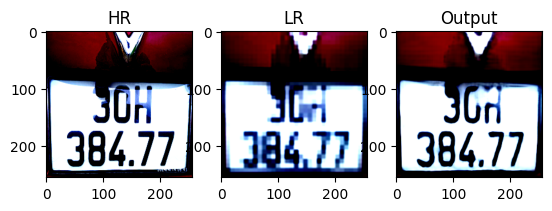

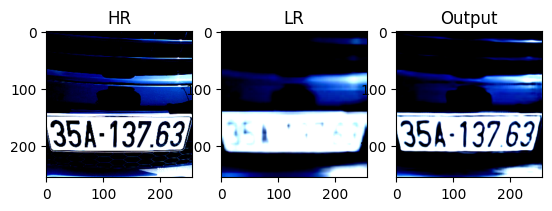

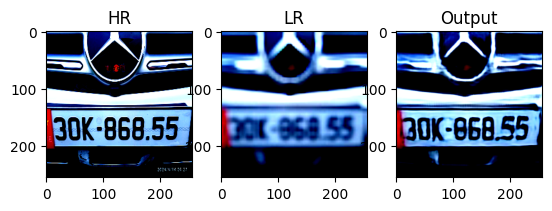

KeyboardInterrupt: 

In [7]:
model.to(device)
image_dataset = LicensePlateDataset(LR_path, HR_path, (256, 256))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=True)
for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = model(LR_image)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.cpu().detach().numpy()
        plt.subplot(1,3,1)
        plt.imshow(HR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("HR")
        plt.subplot(1,3,2)
        plt.imshow(LR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("LR")
        plt.subplot(1,3,3)
        plt.imshow(HR_output)
        plt.title("Output")
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


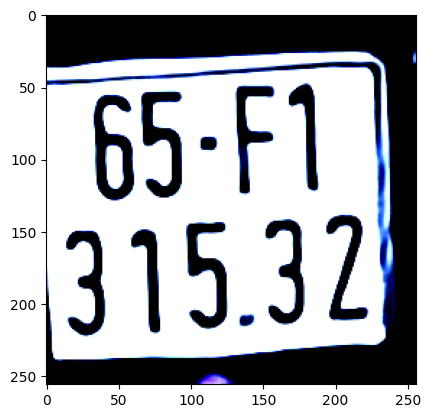

In [27]:
def inference(image, model):
    image = model(image)
    image = image.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    return image
LR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_augmentation\img_HRsumary4357\img_HRsumary"
HR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_augmentation\img_LRsumary4357\img_LRsumary"
dataset = LicensePlateDataset(LR_path, HR_path, (256,256))
LR_image = dataset.__getitem__(0)[0]
HR_output = inference(LR_image.unsqueeze(0).to(device), model)
print(HR_output.shape)
# HR_output = HR_output.permute(1,2,0).detach().cpu().numpy()
# LR_image = LR_image.transpose(2,0)
plt.imshow(HR_output)

In [6]:
import numpy as np
import cv2


def calculate_psnr(original, compressed):
    # Đảm bảo hai hình ảnh có cùng kích thước
    assert original.shape == compressed.shape, "Hình ảnh phải có cùng kích thước"

    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # PSNR vô cùng nếu không có sai khác

    max_pixel = 4.5  # Giả sử hình ảnh có độ sâu 8-bit
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr




In [11]:
import numpy as np
device = 'cuda'
model.to(device)
psnr = []
image_dataset = LicensePlateDataset(LR_path, HR_path, (256, 256))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False)
for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = model(LR_image)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.detach().cpu().numpy()
        
        HR_image = HR_image.squeeze(0).permute(1,2,0)
        HR_image = HR_image.detach().cpu().numpy()
        psnr.append(calculate_psnr(HR_image,HR_output))


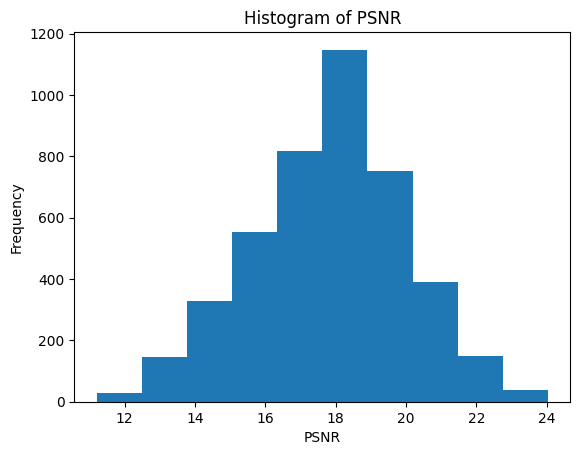

In [12]:
plt.hist(psnr)
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.title("Histogram of PSNR")
plt.show()

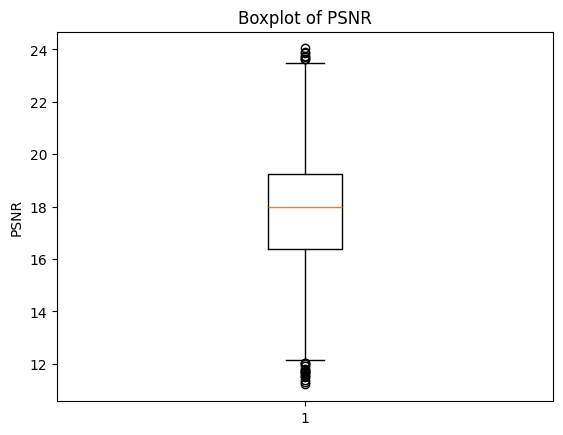

In [13]:
plt.boxplot(psnr)
plt.ylabel("PSNR")
plt.title("Boxplot of PSNR")
plt.show()